## Chapter 4
# Whistler Data

In [2]:
import sys
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from math import ceil
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from sample import Sample
from dataset import Dataset
from database import Database
from sample_detector import SampleDetector
from dataset_simulation import DatasetSimulation

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
site = 'marion'
my_dataset = Dataset(dataset_loc, site)
my_database = Database(dataset_loc, database_loc, site)
dataset_sim = DatasetSimulation(dataset_sim_loc, 0.006395061728395062, 0.15503875968992248)

## 4.3 Simulated Data
2196 files from Marion and 375 files from Sanae

0.4113725220931104
1.6454900883724417
0.41747676690118873
1.669907067604755


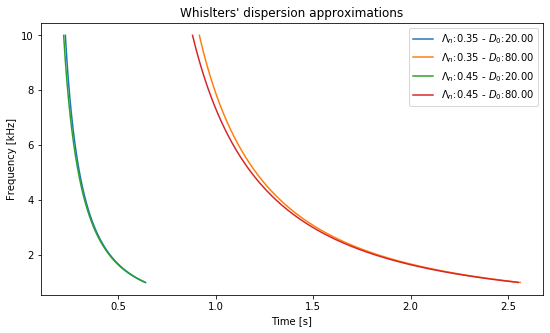

In [2]:

An = 0.35 # 0.35 <= An <= 0.45
D0 = 20 # 20 <= D0 <= 80
legend = []
plt.figure(figsize=(9,5))
for An in np.linspace(0.35, 0.45, 2):
    for D0 in np.linspace(20,80,2):
        t = dataset_sim.whistler_trace(An,D0)
        f = dataset_sim.get_frequency_range()
        print(t.max()-t.min())
        legend.append("$\Lambda_n$:%.2f - $D_0$:%.2f"%(An,D0))
        plt.plot(t,f/1e3)
plt.legend(legend)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.title("Whislters' dispersion approximations" )
plt.show()

(59, 65)


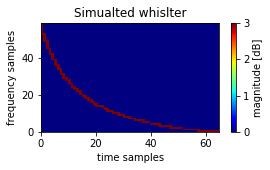

(59, 65)


In [3]:
data = dataset_sim.whistler_sim(An=0.35, D0=20)
print(data.shape)
fig = plt.figure(figsize=(2*ceil(data.shape[1]/data.shape[0]),2))
img = plt.pcolormesh(data, cmap='jet')
fig.colorbar(mappable=img, label='magnitude [dB]')
plt.xlabel('time samples')
plt.ylabel('frequency samples')
plt.title('Simualted whislter')
plt.show()
print(data.shape)

#### Generate whistler simulated dataset

In [2]:
# dataset_sim.whistler_file(An=0.35, D0=20)
# plt.pcolormesh(dataset_sim.load_whistler_file(An=0.35, D0=20))
dataset_sim.generate_whislters()

100%|██████████| 60701/60701 [00:48<00:00, 1248.31it/s]


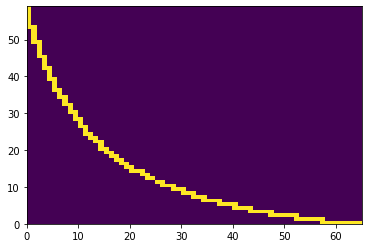

In [9]:
plt.pcolormesh(dataset_sim.load_whistler_file(An=0.357, D0=20.1))

#### Noise generation

In [3]:
import multiprocessing as mp
from sklearn import mixture
import scipy.stats as stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

site = 'marion'
components = 1
my_dataset = Dataset(dataset_loc, site)
def get_spec(file):
    sample = Sample(dataset_loc, site, file)
    spec = sample.get_spectrogram()
    cuts, whistler_len, _ =  sample.cuts(cut_time=0.8, cut_time_split=0.3, cut_freq=9, cut_freq_min=1, time_err=0.3, noise=True)
    whistler_cuts, noise_cuts = cuts[:whistler_len],cuts[whistler_len:]
    noise_spec = np.array([spec[cut[0]:cut[1],cut[2]:cut[3]].flatten() for cut in noise_cuts]).flatten()
    whistler_spec = np.array([spec[cut[0]:cut[1],cut[2]:cut[3]].flatten() for cut in whistler_cuts]).flatten()
    return whistler_spec, noise_spec
files = my_database.get_train()
whistler_specs, noise_specs = [], []
pool = mp.Pool(mp.cpu_count())
# generate 1D array of all spectrogram data
for w_spec, n_spec in tqdm(pool.imap_unordered(get_spec, files), total=len(files)):
    if len(w_spec)>0:
        whistler_specs.append(w_spec)
    if len(n_spec)>0:
        noise_specs.append(n_spec)
pool.close()
pool.join()
print(len(whistler_specs), len(noise_specs))

100%|██████████| 1471/1471 [00:52<00:00, 27.99it/s]


1471 1446


In [4]:
whistler_stats = []
gaussian_whistler_spec = []
for w_spec in tqdm(whistler_specs):
    gaussian_whistler_spec = np.concatenate((gaussian_whistler_spec, w_spec.flatten()))
    whistler_stats.append([w_spec.mean(), w_spec.std()])
gaussian_whistler_spec = np.array(gaussian_whistler_spec)
whistler_stats = np.array(whistler_stats)
print('\nWhistler')
print('Mean = %0.3f+-%.3f'%(whistler_stats[:,0].mean(),whistler_stats[:,0].std()))
print('Std = %0.3f+-%.3f'%(whistler_stats[:,1].mean(),whistler_stats[:,1].std()))

100%|██████████| 1471/1471 [02:54<00:00,  4.24it/s]



Whistler
Mean = 1.415+-0.256
Std = 0.444+-0.045


In [ ]:
# create Gaussian mixture of the data
gaussian_whistler_spec = gaussian_whistler_spec.reshape(-1,1)
g = mixture.GaussianMixture(n_components=components,covariance_type='full')
g.fit(gaussian_whistler_spec)
weights, means, covars = g.weights_, g.means_, g.covariances_
print(components, weights, means, covars)
plt.figure()
legend = [Patch(facecolor='cornflowerblue', edgecolor='b',label='spectrogram\'s histogram'),
                  Line2D([0], [0], color='red', lw=3, label='gaussian distribution[s]')]
plt.hist(gaussian_whistler_spec, bins=100, histtype='bar', density=True, ec='blue', alpha=0.5)
f_axis = gaussian_whistler_spec.copy().ravel()
f_axis.sort()
for i in range(components):
    plt.plot(f_axis,weights[i]*stats.norm.pdf(f_axis,means[i],np.sqrt(covars[i])).ravel(), c='red')
plt.xlabel('noise magnitude [dB]')
plt.legend(handles=legend, loc='upper left')
plt.title('Guassian distribution[s] of noise')
plt.show()

In [ ]:
noise_stats = []
gaussian_noise_spec = []
for n_spec in tqdm(noise_specs):
    gaussian_noise_spec = np.concatenate((gaussian_noise_spec, n_spec.flatten()))
    noise_stats.append([n_spec.mean(), n_spec.std()])
gaussian_noise_spec = np.array(gaussian_noise_spec)
noise_stats = np.array(noise_stats)
print('\nNoise')
print('Mean = %0.3f+-%.3f'%(noise_stats[:,0].mean(),noise_stats[:,0].std()))
print('Std = %0.3f+-%.3f'%(noise_stats[:,1].mean(),noise_stats[:,1].std()))

# create Gaussian mixture of the data
gaussian_noise_spec = gaussian_noise_spec.reshape(-1,1)
g = mixture.GaussianMixture(n_components=components,covariance_type='full')
g.fit(gaussian_noise_spec)
weights, means, covars = g.weights_, g.means_, g.covariances_
print(components, weights, means, covars)
plt.figure()
legend = [Patch(facecolor='cornflowerblue', edgecolor='b',label='spectrogram\'s histogram'),
                  Line2D([0], [0], color='red', lw=3, label='gaussian distribution[s]')]
plt.hist(gaussian_noise_spec, bins=100, histtype='bar', density=True, ec='blue', alpha=0.5)
f_axis = gaussian_noise_spec.copy().ravel()
f_axis.sort()
for i in range(components):
    plt.plot(f_axis,weights[i]*stats.norm.pdf(f_axis,means[i],np.sqrt(covars[i])).ravel(), c='red')
plt.xlabel('noise magnitude [dB]')
plt.legend(handles=legend, loc='upper left')
plt.title('Guassian distribution[s] of noise')
plt.show()